# Advanced lane finding using OpenCV

## 1. Camera Calibration

Our initial goal is to obtain a transformation matrix to map a 3D object to a 2D image and a set of coefficients representative of the distortion due to the optics and setting of the image capturing device. Let's import first the main libraries used for this project:


In [3]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
#qt inline
%matplotlib inline

nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

The camera calibration function receives a set of images from a source and uses cv2.calibrateCamera to obtain the calibration matrix and distortion coefficients

In [3]:
def camera_calibration(images, nx, ny):
    
    # Prepare object points in the format (0,0,0), (0,1,0),..., (8,8,0)
    objp =  np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x and y coordinates. z value is zero for all points

    # Arrays to store object and image points for all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    # Step through the list and search for chess corners
    count = 1
    for fname in images:
        img = cv2.imread(fname)
        
        # Convert image to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret ==  True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    ret, mtx, dist, rvec, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

mtx , dist = camera_calibration(images,nx,ny)

# 2. Distortion correction

The following procedure distort the image and apply color/gradient threshold to clearly identify the lane lines

In [4]:
def undistort_image(img, mtx, dist):
    #1. Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist


## Example of the results so far.

Let's undistort a chessboard image using the matrix and distortion coefficients obtained after camera calibration.

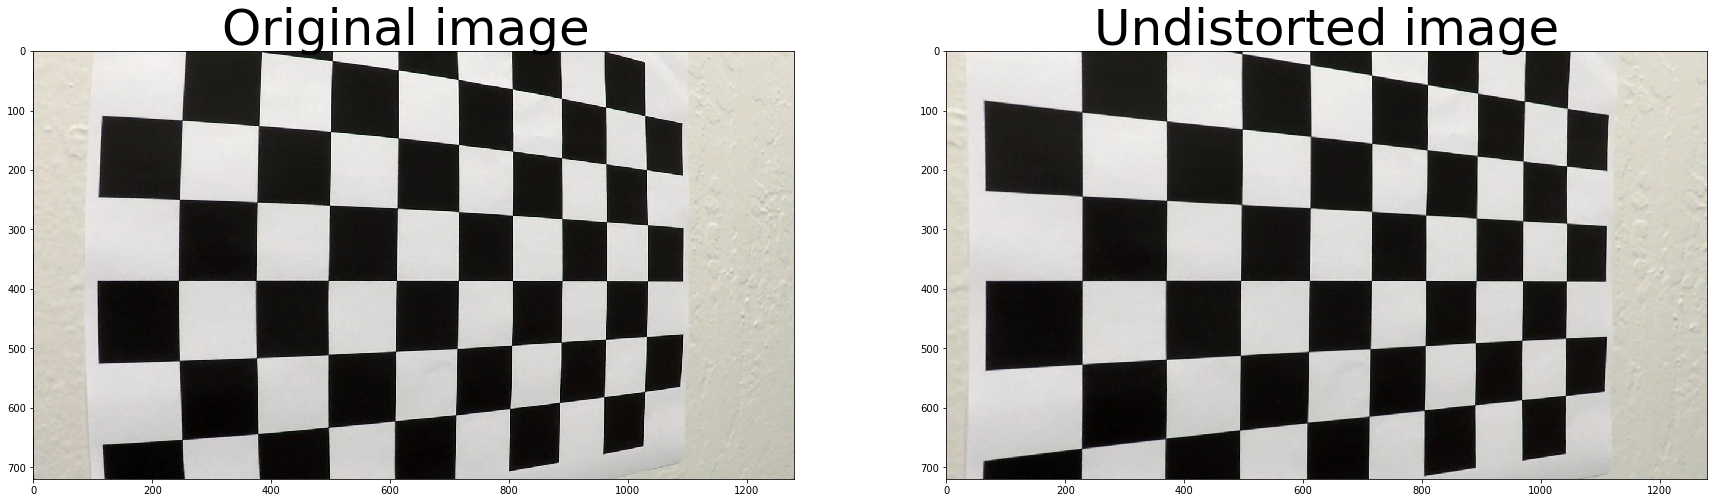

In [5]:
img = mpimg.imread('camera_cal/calibration5.jpg')

undist = undistort_image(img, mtx, dist)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Original image ', fontsize=50)
ax1.imshow(img)

ax2.set_title('Undistorted image', fontsize=50)
ax2.imshow(undist)

# 3. Color and gradient thresholds

In [6]:
def threshold_function(img):
    
    # Transforms image to the HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Define saturation and lightness channel in separata variables
    s_channel = hls[:,:,2] # Takes the saturation channel from the image in HLS color space
    l_channel = hls[:,:,1] # Takes the lightness channel from the image in HLS color space
        
    # Threshold over gradient: Sobel x in the lightness channel 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in the x direction
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(sobelx))
    
    #Threshold x gradient
    thresh_min = 20
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx < thresh_max)] = 1
    
    # Threshold over color: Saturation channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min)&( s_channel < s_thresh_max)] = 1
    
    # Stack both channels to see their individual contributions as blue (saturation channel) and green (sobel x)
    color_binary = np.dstack((np.zeros_like(s_channel), sxbinary, s_binary ))*255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sxbinary==1) | (s_binary==1)] = 1
    
    return combined_binary


## Color and gradient thresholds output

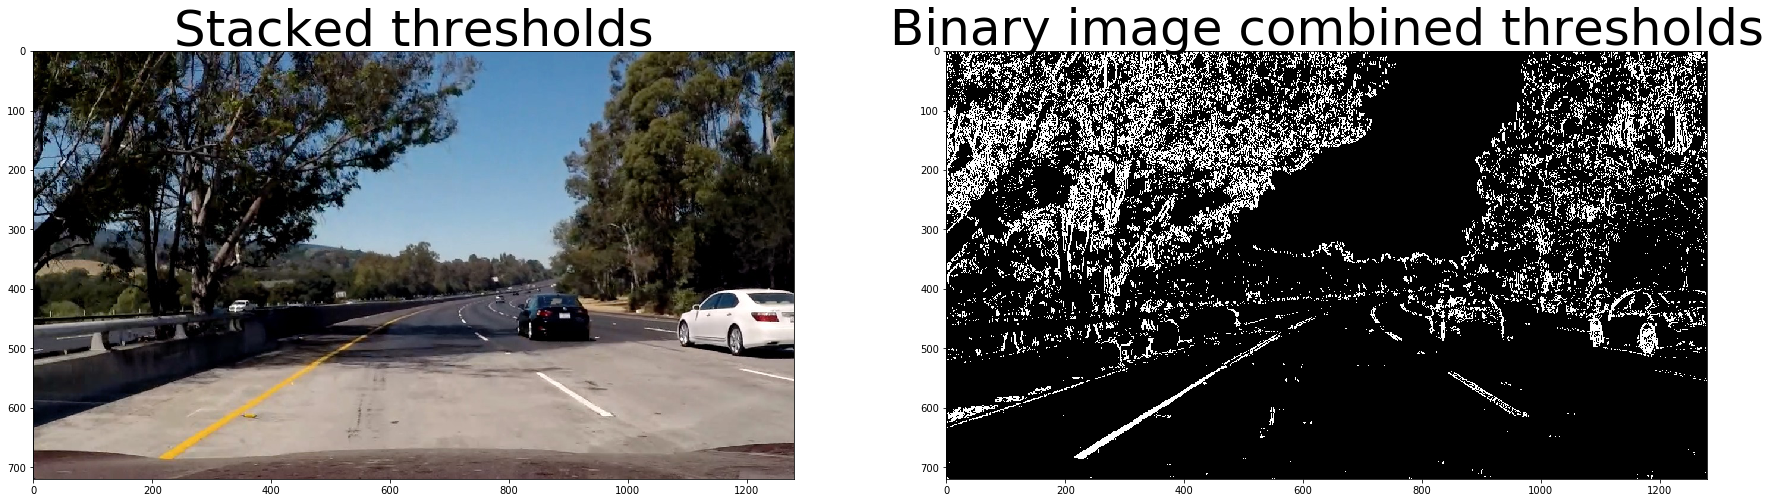

In [7]:
img = mpimg.imread('test_images/test5.jpg')

binary_output=threshold_function(img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Stacked thresholds', fontsize=50)
ax1.imshow(img)

ax2.set_title('Binary image combined thresholds', fontsize=50)
ax2.imshow(binary_output, cmap='gray')
plt.show()

# 4. Perspective transform

Based on previous modifications of the original image now we apply a perspective transform. Our goal is to see the real nature of the lanes as seen from the top down. Lanes should be parallel and clear on the final result

In [8]:
def perspective_transform(img):
    
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])

    offset_left = 245 # offset in x direction at the left side of the warped image
    offset_right = 285 # offset in the x directions at the right side of the warped image

    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[232,img_size[1]-20], [582,460], [701,460], [1075,img_size[1]-20]])

    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset_left,img_size[1]],[offset_left,0],[img_size[0]-offset_right,0],[img_size[0]-offset_right,img_size[1]]])

    #d. Get perspective transform M using the source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    #e. Get the inverse perspective transform Minv using the destination and source points
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    #f. Warp the image captured by the camera using this transform to get an accurate depiction of the 2D image
    warped = cv2.warpPerspective(img, M,  img_size, flags=cv2.INTER_LINEAR)
    #options: cv2.INTER_NEAREST
    
    return warped, M, Minv


## Implementation of the perspective transform

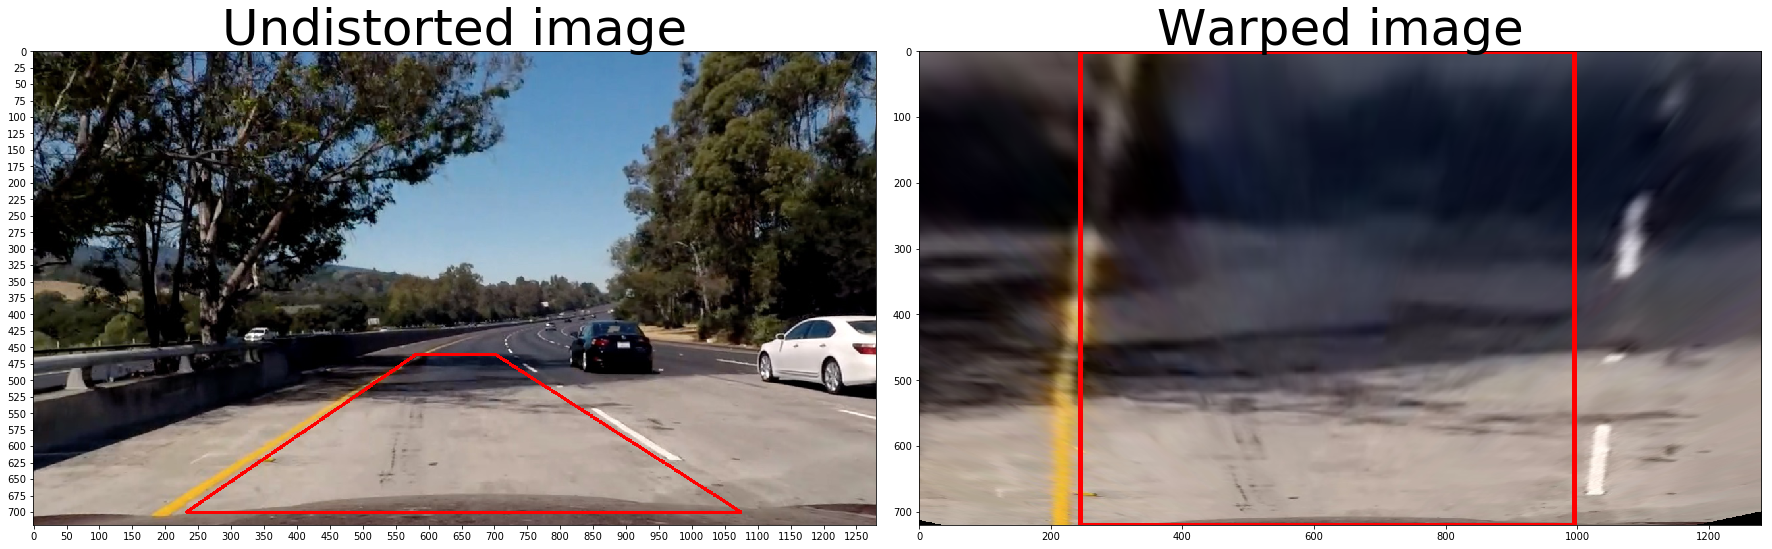

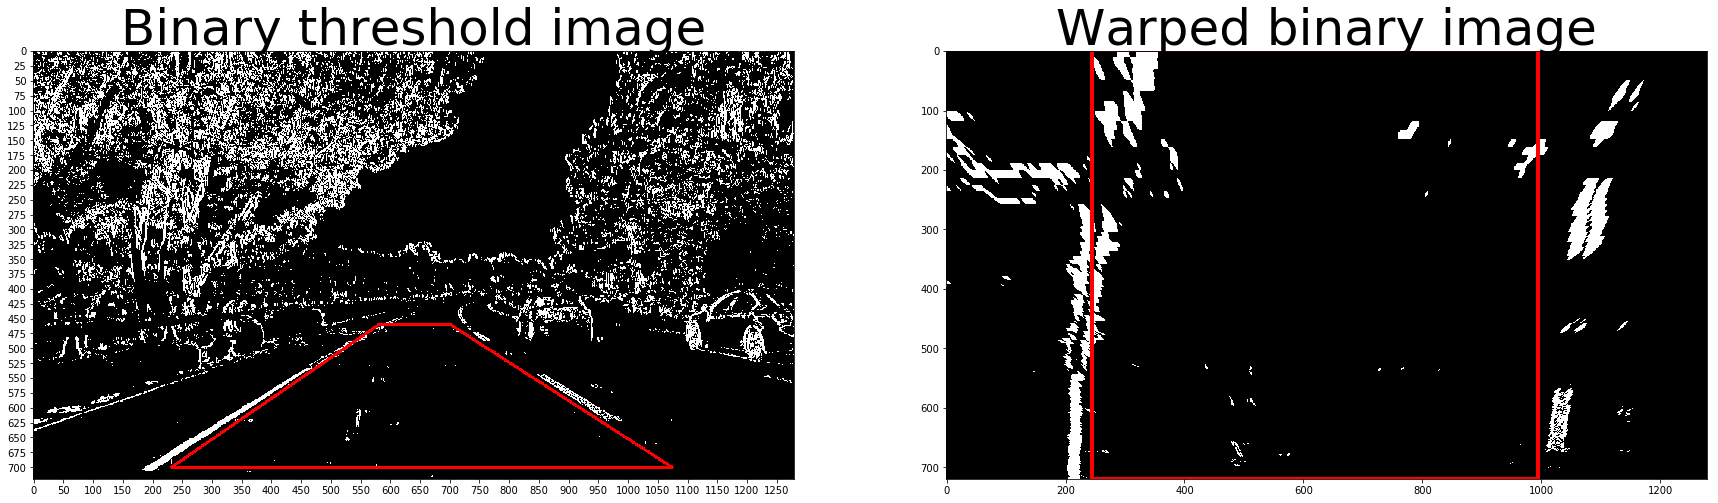

In [9]:
#images = glob.glob('test_images/test*.jpg')
images = ['test_images/test5.jpg']#'test_images/straight_lines1.jpg']

for fname in images:
    img = mpimg.imread(fname)

    # Undistorted image
    undist = undistort_image(img, mtx, dist)
    
    # Combine binary image after the application of gradient in x direction and saturation channel thresholds
    img_thresh = threshold_function(undist)
    
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])
    offset_left = 245 # offset in x direction at the left side of the warped image
    offset_right = 285 # offset in the x directions at the right side of the warped image
    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[232,img_size[1]-20], [582,460], [701,460], [1075,img_size[1]-20]])
    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset_left,img_size[1]],[offset_left,0],[img_size[0]-offset_right,0],[img_size[0]-offset_right,img_size[1]]])
    
    # Warped image using perspective transform over the undistorted image
    warped, perspective_M, Minv = perspective_transform(undist)
    
    # Warped binary image using perspective transform over the combined threshold binary image
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    
    binary_lines = np.dstack((img_thresh, img_thresh, img_thresh))*255

    for i in range(len(src)):
        if i==(len(src)-1):
            cv2.line(undist,tuple(src[0]), tuple(src[i]),(255,0, 0), thickness=3, lineType=8)
            cv2.line(binary_lines,tuple(src[0]), tuple(src[i]),(255,0, 0), thickness=3, lineType=8)
        else:
            cv2.line(undist,tuple(src[i]), tuple(src[i+1]),(255,0, 0), thickness=3, lineType=8)
            cv2.line(binary_lines,tuple(src[i]), tuple(src[i+1]),(255,0, 0), thickness=3, lineType=8)
    
    warped_lines = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    for i in range(len(dst)):
        if i==(len(dst)-1):
            cv2.line(warped,tuple(dst[0]), tuple(dst[i]),(255,0, 0), thickness=5, lineType=8)
            cv2.line(warped_lines,tuple(dst[0]), tuple(dst[i]),(255,0, 0), thickness=5, lineType=8)
        else:
            cv2.line(warped,tuple(dst[i]), tuple(dst[i+1]),(255,0, 0), thickness=5, lineType=8)
            cv2.line(warped_lines,tuple(dst[i]), tuple(dst[i+1]),(255,0, 0), thickness=5, lineType=8)
        
    
    # Plotting undistorted image and warped image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.set_title('Undistorted image', fontsize=50)
    ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
    ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
    ax1.imshow(undist)
    ax2.set_title('Warped image', fontsize= 50)
    ax2.imshow(warped)
    plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
    plt.show()
    # Plotting binary threshold image and warped binary image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
    ax1.set_title('Binary threshold image', fontsize=50)
    ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
    ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
    ax1.imshow(binary_lines)

    ax2.set_title('Warped binary image', fontsize=50)
    ax2.imshow(warped_lines)

# 5. Detect lane lines

Here we find the lane lines using histograms and sliding window techniques. We start from the bottom of the image and move upwards trying to map peaks of the histogram to the most populated active pixels in each window. The following segment shows the functions used to detect the lane lines.

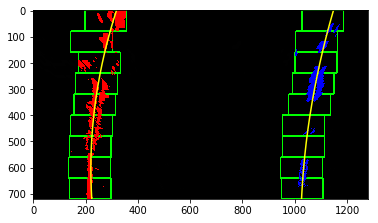

In [11]:
# Find a set of pixels part of the left and right lane when no previous lanes have been identified
def find_lane_pixels_prior(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### 1. Find the four boundaries of the left and right window ###
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 4) 
        
        ### 2. Identify the nonzero pixels in x and y within the window ###
        good_left_inds = []
        good_right_inds = []
       
        for i in range(len(nonzerox)):
            
            if nonzerox[i]> binary_warped.shape[1]:
                print(i, nonzerox[i])
                continue
            # Add nonzero pixels within the windows in left line
            if (nonzerox[i]<win_xleft_high and nonzerox[i]>=win_xleft_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_left_inds += [i]
            # Add nonzero pixels within the windows in right line    
            if (nonzerox[i]<win_xright_high and nonzerox[i]>=win_xright_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_right_inds += [i]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        ### 3. If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # Left window
        nleft = 0
        leftx_sum = 0
        for i in good_left_inds:
            nleft +=  1
            leftx_sum += nonzerox[i]
        if nleft > minpix:
            leftx_current =  leftx_sum//nleft

        # Right window
        nright = 0
        rightx_sum = 0
        for i in good_right_inds:
            nright +=  1
            rightx_sum += nonzerox[i]
        if nright > minpix:
            rightx_current =  rightx_sum//nright
    

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print('Something went wrong with the concatenation step!\n')
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[np.uint(left_lane_inds)]
    lefty = nonzeroy[np.uint(left_lane_inds)] 
    rightx = nonzerox[np.uint(right_lane_inds)]
    righty = nonzeroy[np.uint(right_lane_inds)]

    return leftx, lefty, rightx, righty, out_img

# Find a set of pixels part of the left and right lane when previous lanes have been identified
def find_lane_pixels_posterior(binary_warped, left_fitx, right_fitx):
    pass
    
#Fit a set of pixel coordinates found in a image to a 2nd degree polynomial
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_prior(binary_warped)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ### 4. Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(ym_per_pix*lefty, xm_per_pix*leftx, 2)
    right_fit_cr = np.polyfit(ym_per_pix*righty, xm_per_pix*rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # Calculate the radius of curvature in meters for both lane lines and the vehicle position in meters
    midpoint_x = binary_warped.shape[1]//2
        
    return left_fitx, right_fitx, left_fit_cr, right_fit_cr, out_img


left_fitx, right_fitx, left_fit_cr, right_fit_cr, out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

# 6. Determine the lane curvature and vehicle position


In [13]:
def curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions and the 
    vehicle position from the center of the lanes in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0]) 
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    #x position of the car in the road
    real_midpoint_x = binary_warped.shape[1]*xm_per_pix
    
    #x coordinate of middle point of the lanes
    bottomy= (binary_warped.shape[0]*ym_per_pix)
    right_lane_x = right_fit_cr[0]*bottomy**2 + right_fit_cr[1]*bottomy + right_fit_cr[2]
    left_lane_x = left_fit_cr[0]*(bottomy)**2 + left_fit_cr[1]*bottomy + left_fit_cr[2]
    lane_center_x = (right_lane_x+left_lane_x)//2 
    
    #Distance of the car from the center of the lanes
    distance_from_center = real_midpoint_x-lane_center_x
    
    return left_curverad, right_curverad, distance_from_center

## Implementation of curvature and position estimation function

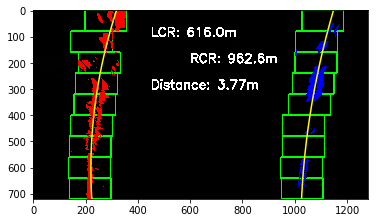

In [27]:
left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped, left_fit_cr, right_fit_cr)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

# Text visualization parameters
fontFace=cv2.FONT_HERSHEY_SIMPLEX
fontScale= 1.6
color = (255,255,255)
lineType = 5

#Left lane curvature - LCR
cv2.putText(out_img, 'LCR: {0:.1f}'.format(left_curverad)+'m', (450,100), fontFace, fontScale, color, lineType) 
#Right lane curvature - RCR
cv2.putText(out_img, 'RCR: {0:.1f}'.format(right_curverad)+'m', (600,200),fontFace, fontScale, color, lineType) 
# Vehicle position from the lanes midpoint - Positive values indicate to the right, negative to the left of
# the lanes midpoint
cv2.putText(out_img, 'Distance: {0:.2f}'.format(distance_from_center)+'m', (450,300),fontFace, fontScale, color, lineType) 
plt.imshow(out_img)

# 7. Draw lanes in the original image

In [28]:
def draw_lanes(undist, warped, Minv, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


# Advanced lane finding pipeline (without line tracking)

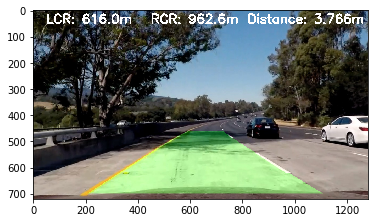

In [29]:
def advanced_pipeline(img):
    
    undist = undistort_image(img, mtx, dist)
    
    img_thresh = threshold_function(undist)
    
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    left_fitx, right_fitx, left_fit_cr, right_fit_cr, out_img = fit_polynomial(binary_warped)
    
    left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr)
    
    final = draw_lanes(undist, binary_warped, Minv, left_fitx, right_fitx)
    
    cv2.putText(final, 'LCR: {0:.1f}'.format(left_curverad)+'m', (50,50), fontFace, fontScale, color, lineType) 
    cv2.putText(final, 'RCR: {0:.1f}'.format(right_curverad)+'m', (450,50),fontFace, fontScale, color, lineType) 
    cv2.putText(final, 'Distance: {0:.3f}'.format(distance_from_center)+'m', (820,50),fontFace, fontScale, color, lineType) 
    return final 

image = 'test_images/test5.jpg'
img = mpimg.imread(image)

fimage= advanced_pipeline(img)
plt.gcf().clear()
plt.imshow(fimage)


# Advanced lane finding pipeline (without line tracking)

In this section I will create a Line class to track the lanes in different frames and operate with data stored over time

In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    '''
    Line lane class. Stored the main attributes of the line abstraction and defines
    useful methods to process the line lanes in different frames
    '''
    def __init__(self, lane_type, buffer_size):
        #number of iterations where data is going to be stored
        self.buffer_size = buffer_size
        #lane type
        if lane_type in ['left', 'right']:
            self.lane_type = lane_type
        else:
            raise Exception('Incorrect lane type.')
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

line = Line('red')

Exception: Incorrect lane type.

# Processing video

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # DONE: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Use mode=0 to get raw lines as output over the original image. mode = 1 will offer two solid lines instead
    result = advanced_pipeline(image)
    return result

In [30]:
input = 'project_video.mp4'

output ='estimation_output_project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(input).subclip(0,3)
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)
plt.gcf().clear()

[MoviePy] >>>> Building video estimation_output_project_video.mp4
[MoviePy] Writing video estimation_output_project_video.mp4


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 75/76 [01:01<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: estimation_output_project_video.mp4 

Wall time: 1min 2s


<Figure size 432x288 with 0 Axes>

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))